# Import

In [102]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.utils.tensorboard
import torchvision
import torchvision.transforms
import os
import time
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.model_selection as model_selection
from tqdm import tqdm
from glob import glob
from IPython.display import clear_output
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Dataset

In [103]:
!git clone https://github.com/soniamartinot/MVA-Dose-Prediction.git

fatal: destination path 'MVA-Dose-Prediction' already exists and is not an empty directory.


In [104]:
all_training_samples = "./MVA-Dose-Prediction/train/*"
print("Length of training set:", len(glob(all_training_samples)))

Length of training set: 7800


In [105]:
all_validation_samples = "./MVA-Dose-Prediction/validation/*"
print("Length of validation set:", len(glob(all_validation_samples)))

Length of validation set: 1200


In [106]:
all_test_samples = "./MVA-Dose-Prediction/test/*"
print("Length of test set:", len(glob(all_test_samples)))

Length of test set: 1200


In [107]:
class DoseDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.samples = os.listdir(data_path)
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_path = self.data_path + os.sep + self.samples[idx]
        ct_scan = torch.from_numpy(np.load(sample_path + os.sep + 'ct.npy')).float()
        ct_scan = F.normalize(ct_scan, p=2.0, dim=1, eps=1e-12, out=None).float()
        possible_dose_mask = torch.from_numpy(np.load(sample_path + os.sep + 'possible_dose_mask.npy')).float()
        dose = torch.from_numpy(np.load(sample_path + os.sep + 'dose.npy')).float()
        structure_masks = torch.from_numpy(np.load(sample_path + os.sep + 'structure_masks.npy')).float()
        features = torch.vstack([ct_scan.unsqueeze(0), structure_masks, possible_dose_mask.unsqueeze(0)])


        return (features, dose)


In [108]:
train_dir = "./MVA-Dose-Prediction/train/"


train_dataset = DoseDataset(train_dir)
train_loader = DataLoader(train_dataset, batch_size=16, num_workers=1, shuffle=True, pin_memory=True)

In [109]:
val_dir = "./MVA-Dose-Prediction/validation"

val_dataset = DoseDataset(val_dir)
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=1, shuffle=True, pin_memory=True)

In [110]:
train_dataset[0][0][0].shape

torch.Size([128, 128])

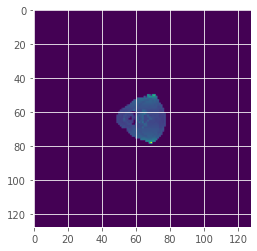

In [111]:
plt.imshow(train_dataset[2][0][0])
plt.show()

In [112]:
torch.max((train_dataset[2][0][0]))

tensor(0.8453)

In [113]:
train_dataset[2][0][0].shape

torch.Size([128, 128])

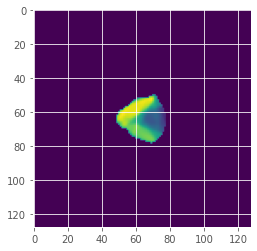

In [114]:
plt.imshow(train_dataset[2][1])
plt.show()

# Model

In [115]:
def get_activation(activation_type):
    activation_type = activation_type.lower()
    if hasattr(nn, activation_type):  return getattr(nn, activation_type)()
    else:  return nn.ReLU()

In [116]:
class ConvBatchNorm(nn.Module):
    """This block implements the sequence: (convolution => [BN] => ReLU)"""  
    def __init__(self, in_channels, out_channels, activation='GELU'):
        super(ConvBatchNorm, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 
                              kernel_size=3, padding=1)
        self.norm = nn.BatchNorm2d(out_channels)
        self.activation = get_activation(activation)
        #self.dropout = nn.Dropout(p = 0.15)
      
    def forward(self, x):
        out = self.conv(x)
        out = self.norm(out)
      #  return self.dropout(self.activation(out))
        return self.activation(out)
    

In [117]:
def _make_nConv(in_channels, out_channels, nb_Conv, activation='GELU'):
    layers = []
    layers.append(ConvBatchNorm(in_channels, out_channels, activation))
    for _ in range(nb_Conv-1):
        layers.append(ConvBatchNorm(out_channels, out_channels, activation))
    return nn.Sequential(*layers)

In [118]:
class DownBlock(nn.Module):
    """Downscaling with maxpooling and convolutions"""
    def __init__(self, in_channels, out_channels, nb_Conv, activation='GELU'):
        super(DownBlock, self).__init__()
        self.maxpool = nn.MaxPool2d(2)
        self.nConvs = _make_nConv(in_channels, out_channels, nb_Conv, activation)

    def forward(self, x):
        out = self.maxpool(x)
        return self.nConvs(out)  

In [119]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, nb_Conv=2, activation='GELU'):
        super(Bottleneck, self).__init__()
        self.nConvs = _make_nConv(in_channels, out_channels, nb_Conv, activation)
        self.last = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)
    def forward(self, input):
        out = self.nConvs(input)
        #out = self.last(out)
        return out

In [120]:
class UpBlock(nn.Module):
    """Upscaling then conv"""
    def __init__(self, in_channels, out_channels, nb_Conv=2, activation='GELU'):
        super(UpBlock, self).__init__()        
        #nn.Upsample(scale_factor=2)
        self.nConvs = _make_nConv(in_channels, out_channels, nb_Conv, activation)
        self.up = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2, padding=0)

    def forward(self, x, skip_x):
        #print(f"shape of x", x.shape)
        #print(f"shape of skip_x", skip_x.shape)
        x = torch.cat([x, skip_x], dim=1)
        #print(x.shape)
        x = self.nConvs(x)
        #print(x.shape)
         # dim 1 is the channel dimension
        return self.up(x)

In [121]:
class UNet(nn.Module):
    def __init__(self, n_channels=12):
        '''
        n_channels : number of channels of the input. 
                        By default 12, because we have 12 modalities
        '''
        super(UNet, self).__init__()
        self.n_channels = n_channels

        # Question here
        self.inc1 = ConvBatchNorm(n_channels, 64)
        self.inc2 = ConvBatchNorm(64, 64)
        self.down1 = DownBlock(64, 128, nb_Conv=2)
        self.down2 = DownBlock(128, 256, nb_Conv=2)
        self.down3 = DownBlock(256, 512, nb_Conv=2)
        self.down4 = DownBlock(512, 512, nb_Conv=2)

        self.Encoder = [self.down1, self.down2, self.down3, self.down4]

        self.bottleneck = Bottleneck(512, 512)

        self.up1 = UpBlock(1024, 256, nb_Conv=2)
        self.up2 = UpBlock(768, 256, nb_Conv=2)
        self.up3 = UpBlock(512, 128, nb_Conv=2)
        self.up4 = UpBlock(256, 64, nb_Conv=2)


        self.Decoder = [self.up1, self.up2, self.up3, self.up4]

        self.outc = nn.Sequential(ConvBatchNorm(128, 32),
                                nn.Conv2d(32, 16, 
                              kernel_size=3, padding=1),
                              nn.Conv2d(16, 8, 
                              kernel_size=3, padding=1),
                              nn.Conv2d(8, 4, 
                              kernel_size=3, padding=1),
                              nn.Conv2d(4, 2, 
                              kernel_size=3, padding=1),
                              nn.Conv2d(2, 1, 
                              kernel_size=1, padding=0),
        )
        self.last_activation = get_activation('relu')

    
    def forward(self, x):
        # Forward 
        skip_inputs = []
        x = self.inc2(self.inc2(self.inc1(x)))
        #print(x.shape)
        # Forward through encoder
        for i, block in enumerate(self.Encoder):
            skip_inputs += [x]
            x = block(x)  
            #print(f"down bloc{i+1}", x.shape)

        skip_inputs += [x]                                      
        # We are at the bottleneck.
        bottleneck = self.bottleneck(x)
        #print(f"bottleneck", bottleneck.shape)

        # Forward through decoder
        skip_inputs.reverse()

        decoded = bottleneck
        for i, block in enumerate(self.Decoder):
            #Concat with skipconnections
            skipped = skip_inputs[i]
            #print(skipped.shape, decoded.shape)
            decoded = block(decoded, skipped)
            #print(f"up block {i+1}", decoded.shape)
        #print(decoded.shape)
        #print(skip_inputs[-1].shape)
        out = self.last_activation(self.outc(torch.cat([decoded, skip_inputs[-1]], dim=1)))
        return out.squeeze(1)

In [122]:
unet = UNet(n_channels=12)


In [123]:
y = unet(val_dataset[0][0].unsqueeze(0))


In [124]:
print(y.shape)

torch.Size([1, 128, 128])


# Training

In [125]:
model = UNet(n_channels=12) # Create model
model.cuda() # move model to GPU

UNet(
  (inc1): ConvBatchNorm(
    (conv): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (inc2): ConvBatchNorm(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (down1): DownBlock(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (nConvs): Sequential(
      (0): ConvBatchNorm(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (1): ConvBatchNorm(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.

In [126]:
learning_rate = 2*1e-4

criterion = nn.L1Loss() # Choose loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Choose optimize
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 50, 70], gamma=0.5)

In [127]:
epochs = 60
# initialize a dictionary to store training history
H = {"train_loss": [], "val_loss": []}

In [128]:
print("[INFO] training the network...")

startTime = time.time()

for e in tqdm(range(epochs)):
	# set the model in training mode
	model.train()
 
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0

	# loop over the training set
	for (features , dose) in train_loader:
		# send the input to the device
		(features, dose) = (features.to(device), dose.to(device))


		# perform a forward pass and calculate the training loss
		optimizer.zero_grad()
  
	

		dose_pred = model(features)
		loss = criterion(dose_pred, dose)

			#Replaces pow(2.0) with abs() for L1 regularization
		
		'''l2_lambda = 0.001
		l2_norm = sum(p.pow(2.0).sum()
				for p in model.parameters())
	
		loss = loss + l2_lambda * l2_norm'''
  

		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		

		loss.backward()
  
		optimizer.step()
		
  
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		
	scheduler.step()


	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()
		# loop over the validation set
		for (features, dose) in val_loader:
			# send the input to the device
			(features, dose) = (features.to(device), dose.to(device))
			# make the predictions and calculate the validation loss
			dose_pred = model(features)
			totalValLoss += criterion(dose_pred, dose)
   
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / len(train_loader)
	avgValLoss = totalValLoss / len(val_loader)
 

	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())
 

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, epochs))
	print("Train loss: {:.6f}, Val loss: {:.4f}".format(avgTrainLoss, avgValLoss))
 

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


  2%|▏         | 1/60 [00:23<23:34, 23.97s/it]

[INFO] EPOCH: 1/60
Train loss: 0.910577, Val loss: 0.9916


  3%|▎         | 2/60 [00:48<23:19, 24.13s/it]

[INFO] EPOCH: 2/60
Train loss: 0.566021, Val loss: 0.6966


  5%|▌         | 3/60 [01:12<22:58, 24.19s/it]

[INFO] EPOCH: 3/60
Train loss: 0.525341, Val loss: 0.7880


  7%|▋         | 4/60 [01:36<22:42, 24.32s/it]

[INFO] EPOCH: 4/60
Train loss: 0.499452, Val loss: 0.5697


  8%|▊         | 5/60 [02:01<22:23, 24.43s/it]

[INFO] EPOCH: 5/60
Train loss: 0.464295, Val loss: 0.5632


 10%|█         | 6/60 [02:25<21:55, 24.36s/it]

[INFO] EPOCH: 6/60
Train loss: 0.443511, Val loss: 0.5288


 12%|█▏        | 7/60 [02:51<21:46, 24.65s/it]

[INFO] EPOCH: 7/60
Train loss: 0.427189, Val loss: 0.5691


 13%|█▎        | 8/60 [03:15<21:21, 24.64s/it]

[INFO] EPOCH: 8/60
Train loss: 0.415575, Val loss: 0.5003


 15%|█▌        | 9/60 [03:39<20:49, 24.50s/it]

[INFO] EPOCH: 9/60
Train loss: 0.406491, Val loss: 0.5111


 17%|█▋        | 10/60 [04:04<20:33, 24.67s/it]

[INFO] EPOCH: 10/60
Train loss: 0.395995, Val loss: 0.4468


 18%|█▊        | 11/60 [04:29<20:03, 24.55s/it]

[INFO] EPOCH: 11/60
Train loss: 0.384795, Val loss: 0.5224


 20%|██        | 12/60 [04:53<19:32, 24.42s/it]

[INFO] EPOCH: 12/60
Train loss: 0.377604, Val loss: 0.4728


 22%|██▏       | 13/60 [05:17<19:03, 24.33s/it]

[INFO] EPOCH: 13/60
Train loss: 0.369198, Val loss: 0.4387


 23%|██▎       | 14/60 [05:41<18:36, 24.26s/it]

[INFO] EPOCH: 14/60
Train loss: 0.358977, Val loss: 0.4773


 25%|██▌       | 15/60 [06:05<18:07, 24.16s/it]

[INFO] EPOCH: 15/60
Train loss: 0.349725, Val loss: 0.4251


 27%|██▋       | 16/60 [06:29<17:43, 24.18s/it]

[INFO] EPOCH: 16/60
Train loss: 0.341864, Val loss: 0.4338


 28%|██▊       | 17/60 [06:53<17:17, 24.12s/it]

[INFO] EPOCH: 17/60
Train loss: 0.336962, Val loss: 0.4653


 30%|███       | 18/60 [07:18<16:57, 24.21s/it]

[INFO] EPOCH: 18/60
Train loss: 0.327172, Val loss: 0.4387


 32%|███▏      | 19/60 [07:42<16:29, 24.12s/it]

[INFO] EPOCH: 19/60
Train loss: 0.320250, Val loss: 0.4747


 33%|███▎      | 20/60 [08:06<16:06, 24.15s/it]

[INFO] EPOCH: 20/60
Train loss: 0.314505, Val loss: 0.4653


 35%|███▌      | 21/60 [08:30<15:44, 24.21s/it]

[INFO] EPOCH: 21/60
Train loss: 0.285369, Val loss: 0.4193


 37%|███▋      | 22/60 [08:54<15:17, 24.15s/it]

[INFO] EPOCH: 22/60
Train loss: 0.275377, Val loss: 0.4376


 38%|███▊      | 23/60 [09:18<14:50, 24.08s/it]

[INFO] EPOCH: 23/60
Train loss: 0.269358, Val loss: 0.4408


 40%|████      | 24/60 [09:42<14:25, 24.03s/it]

[INFO] EPOCH: 24/60
Train loss: 0.263651, Val loss: 0.4348


 42%|████▏     | 25/60 [10:06<14:01, 24.05s/it]

[INFO] EPOCH: 25/60
Train loss: 0.257125, Val loss: 0.4366


 43%|████▎     | 26/60 [10:30<13:40, 24.14s/it]

[INFO] EPOCH: 26/60
Train loss: 0.250435, Val loss: 0.4512


 45%|████▌     | 27/60 [10:54<13:14, 24.08s/it]

[INFO] EPOCH: 27/60
Train loss: 0.246572, Val loss: 0.4317


 47%|████▋     | 28/60 [11:18<12:48, 24.01s/it]

[INFO] EPOCH: 28/60
Train loss: 0.241289, Val loss: 0.4322


 48%|████▊     | 29/60 [11:42<12:22, 23.97s/it]

[INFO] EPOCH: 29/60
Train loss: 0.237373, Val loss: 0.4187


 50%|█████     | 30/60 [12:06<11:59, 23.99s/it]

[INFO] EPOCH: 30/60
Train loss: 0.232006, Val loss: 0.4403


 52%|█████▏    | 31/60 [12:30<11:35, 23.97s/it]

[INFO] EPOCH: 31/60
Train loss: 0.226920, Val loss: 0.4095


 53%|█████▎    | 32/60 [12:54<11:11, 23.98s/it]

[INFO] EPOCH: 32/60
Train loss: 0.222792, Val loss: 0.4407


 55%|█████▌    | 33/60 [13:18<10:49, 24.04s/it]

[INFO] EPOCH: 33/60
Train loss: 0.218569, Val loss: 0.4200


 57%|█████▋    | 34/60 [13:42<10:25, 24.06s/it]

[INFO] EPOCH: 34/60
Train loss: 0.216288, Val loss: 0.4231


 58%|█████▊    | 35/60 [14:07<10:02, 24.10s/it]

[INFO] EPOCH: 35/60
Train loss: 0.211006, Val loss: 0.4368


 60%|██████    | 36/60 [14:31<09:37, 24.08s/it]

[INFO] EPOCH: 36/60
Train loss: 0.209212, Val loss: 0.4127


 62%|██████▏   | 37/60 [14:55<09:13, 24.06s/it]

[INFO] EPOCH: 37/60
Train loss: 0.203189, Val loss: 0.4147


 63%|██████▎   | 38/60 [15:19<08:49, 24.08s/it]

[INFO] EPOCH: 38/60
Train loss: 0.201016, Val loss: 0.4235
[INFO] EPOCH: 39/60
Train loss: 0.196570, Val loss: 0.4278


 67%|██████▋   | 40/60 [16:07<08:03, 24.16s/it]

[INFO] EPOCH: 40/60
Train loss: 0.194660, Val loss: 0.4114


 68%|██████▊   | 41/60 [16:31<07:37, 24.08s/it]

[INFO] EPOCH: 41/60
Train loss: 0.191570, Val loss: 0.4170
[INFO] EPOCH: 42/60
Train loss: 0.189010, Val loss: 0.4088


 72%|███████▏  | 43/60 [17:19<06:48, 24.02s/it]

[INFO] EPOCH: 43/60
Train loss: 0.185581, Val loss: 0.4218


 73%|███████▎  | 44/60 [17:43<06:25, 24.11s/it]

[INFO] EPOCH: 44/60
Train loss: 0.182645, Val loss: 0.4162


 75%|███████▌  | 45/60 [18:07<06:02, 24.15s/it]

[INFO] EPOCH: 45/60
Train loss: 0.180972, Val loss: 0.4239


 77%|███████▋  | 46/60 [18:32<05:38, 24.18s/it]

[INFO] EPOCH: 46/60
Train loss: 0.177467, Val loss: 0.4141


 78%|███████▊  | 47/60 [18:56<05:13, 24.13s/it]

[INFO] EPOCH: 47/60
Train loss: 0.175491, Val loss: 0.4242


 80%|████████  | 48/60 [19:20<04:49, 24.14s/it]

[INFO] EPOCH: 48/60
Train loss: 0.174409, Val loss: 0.4081


 82%|████████▏ | 49/60 [19:44<04:26, 24.21s/it]

[INFO] EPOCH: 49/60
Train loss: 0.170300, Val loss: 0.4135


 83%|████████▎ | 50/60 [20:08<04:01, 24.15s/it]

[INFO] EPOCH: 50/60
Train loss: 0.168673, Val loss: 0.4090


 85%|████████▌ | 51/60 [20:33<03:38, 24.22s/it]

[INFO] EPOCH: 51/60
Train loss: 0.154893, Val loss: 0.4109


 87%|████████▋ | 52/60 [20:57<03:13, 24.21s/it]

[INFO] EPOCH: 52/60
Train loss: 0.150756, Val loss: 0.4082


 88%|████████▊ | 53/60 [21:21<02:50, 24.29s/it]

[INFO] EPOCH: 53/60
Train loss: 0.148539, Val loss: 0.4087


 90%|█████████ | 54/60 [21:46<02:25, 24.29s/it]

[INFO] EPOCH: 54/60
Train loss: 0.147138, Val loss: 0.4051


 92%|█████████▏| 55/60 [22:10<02:01, 24.29s/it]

[INFO] EPOCH: 55/60
Train loss: 0.146211, Val loss: 0.4083


 93%|█████████▎| 56/60 [22:34<01:37, 24.34s/it]

[INFO] EPOCH: 56/60
Train loss: 0.144367, Val loss: 0.4049


 95%|█████████▌| 57/60 [22:58<01:12, 24.28s/it]

[INFO] EPOCH: 57/60
Train loss: 0.143344, Val loss: 0.4095


 97%|█████████▋| 58/60 [23:23<00:48, 24.37s/it]

[INFO] EPOCH: 58/60
Train loss: 0.141518, Val loss: 0.4113


 98%|█████████▊| 59/60 [23:47<00:24, 24.38s/it]

[INFO] EPOCH: 59/60
Train loss: 0.140471, Val loss: 0.4047


100%|██████████| 60/60 [24:12<00:00, 24.21s/it]

[INFO] EPOCH: 60/60
Train loss: 0.138629, Val loss: 0.4020
[INFO] total time taken to train the model: 1452.60s


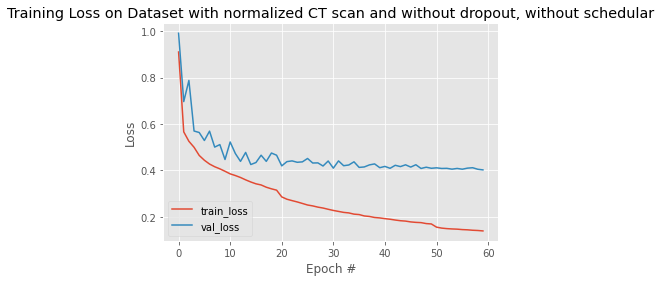

In [130]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset with normalized CT scan and without dropout, without schedular")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()
# serialize the model to disk

In [ ]:
torch.save(model, "/content/drive/MyDrive/MVA/3DM/model5.pth")

## Validation procedure

In [131]:
def mean_absolute_error(image_true, image_generated):
    """Compute mean absolute error.

    Args:
        image_true: (Tensor) true image
        image_generated: (Tensor) generated image

    Returns:
        mse: (float) mean squared error
    """
    return torch.abs(image_true - image_generated).mean()


def peak_signal_to_noise_ratio(image_true, image_generated):
    """"Compute peak signal-to-noise ratio.

    Args:
        image_true: (Tensor) true image
        image_generated: (Tensor) generated image

    Returns:
        psnr: (float) peak signal-to-noise ratio"""
    mse = ((image_true - image_generated) ** 2).mean().cpu()
    return -10 * np.log10(mse)


def structural_similarity_index(image_true, image_generated, C1=0.01, C2=0.03):
    """Compute structural similarity index.

    Args:
        image_true: (Tensor) true image
        image_generated: (Tensor) generated image
        C1: (float) variable to stabilize the denominator
        C2: (float) variable to stabilize the denominator

    Returns:
        ssim: (float) mean squared error"""
    mean_true = image_true.mean()
    mean_generated = image_generated.mean()
    std_true = image_true.std()
    std_generated = image_generated.std()
    covariance = (
        (image_true - mean_true) * (image_generated - mean_generated)).mean()

    numerator = (2 * mean_true * mean_generated + C1) * (2 * covariance + C2)
    denominator = ((mean_true ** 2 + mean_generated ** 2 + C1) *
                   (std_true ** 2 + std_generated ** 2 + C2))
    return numerator / denominator

In [134]:
def evaluate_generator(generator):
    """Evaluate a generator.

    Args:
        generator: (GeneratorUNet) neural network generating T2-w images

    """
    res_train, res_test = [], []

    cuda = True if torch.cuda.is_available() else False
    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

    with torch.no_grad():

        for (features, dose) in train_loader:
            # send the input to the device
            (features, dose) = (features.to(device), dose.to(device))
            # make the predictions and calculate the validation loss
            dose_pred = model(features)

            #compute the different metrics
            mae = mean_absolute_error(dose_pred, dose).item()
            psnr = peak_signal_to_noise_ratio(dose_pred, dose).item()
            ssim = structural_similarity_index(dose_pred, dose).item()

            res_train.append([mae, psnr, ssim])

        for (features, dose) in val_loader:
           # send the input to the device
            (features, dose) = (features.to(device), dose.to(device))
            # make the predictions and calculate the validation loss
            dose_pred = model(features)


            mae = mean_absolute_error(dose_pred, dose).item()
            psnr = peak_signal_to_noise_ratio(dose_pred, dose).item()
            ssim = structural_similarity_index(dose_pred, dose).item()

            res_test.append([mae, psnr, ssim])

        df = pd.DataFrame([
            pd.DataFrame(res_train, columns=['MAE', 'PSNR', 'SSIM']).mean().squeeze(),
            pd.DataFrame(res_test, columns=['MAE', 'PSNR', 'SSIM']).mean().squeeze()
        ], index=['Training set', 'Test set']).T
    return df

In [135]:
evaluate_generator(model)

,Training set,Test set
MAE,0.193598,0.401965
PSNR,0.731046,-5.873433
SSIM,0.996648,0.982932


# Submission

In [ ]:
model = torch.load("/content/drive/MyDrive/MVA/3DM/model5.pth")

In [136]:
model.eval()

UNet(
  (inc1): ConvBatchNorm(
    (conv): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (inc2): ConvBatchNorm(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (down1): DownBlock(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (nConvs): Sequential(
      (0): ConvBatchNorm(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (1): ConvBatchNorm(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.

In [137]:
x , y = val_dataset[0]

In [138]:
x = x.unsqueeze(0)
x.shape

torch.Size([1, 12, 128, 128])

In [139]:
y.shape

torch.Size([128, 128])

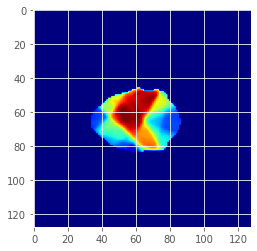

Text(0.5, 1.0, 'real dose')

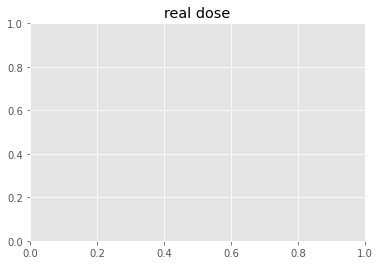

In [147]:
plt.imshow(y,cmap='jet')
plt.show()
plt.title('real dose')

In [141]:
with torch.no_grad():
    pred = model(x.cuda()).squeeze()

In [142]:
pred = pred.cpu()

In [143]:
pred.shape

torch.Size([128, 128])

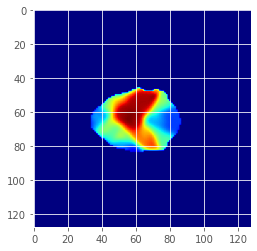

Text(0.5, 1.0, 'generated dose')

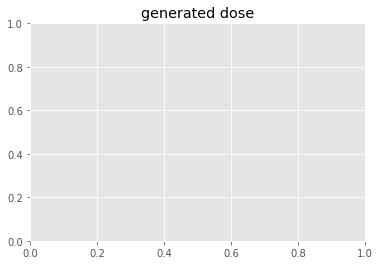

In [145]:
plt.imshow(pred,cmap='jet')
plt.show()
plt.title('generated dose')

In [76]:
loss = torch.nn.L1Loss()

In [77]:
print(loss(pred, y))

tensor(0.4112)


In [78]:
test_dir = "./MVA-Dose-Prediction/test/"

In [80]:
from google.colab import drive
drive.mount('/content/drive')
model.eval()

for sample in tqdm(os.listdir(test_dir)):

    sample_path = test_dir + sample

    ct_scan = torch.from_numpy(np.load(sample_path + os.sep + 'ct.npy')).float()

    ct_scan = F.normalize(ct_scan, p=2.0, dim=1, eps=1e-12, out=None)

    structure_masks = torch.from_numpy(np.load(sample_path + os.sep + 'structure_masks.npy')).float()

    possible_dose_mask = torch.from_numpy(np.load(sample_path + os.sep + 'possible_dose_mask.npy')).float()

    x = torch.vstack([ct_scan.unsqueeze(0), structure_masks, possible_dose_mask.unsqueeze(0)]).unsqueeze(0)

    x = x.cuda()

    with torch.no_grad():

        pred = model(x)

        pred = pred.squeeze().cpu().numpy()
        with open(f"/content/drive/MyDrive/submission/{sample}.npy", "wb") as f:

            np.save(f,pred)
       

        

Mounted at /content/drive


100%|██████████| 1200/1200 [00:16<00:00, 73.86it/s]


In [88]:
cd /content/drive/MyDrive/MVA/3DM/submission

[Errno 2] No such file or directory: '/content/drive/MyDrive/MVA/3DM/submission'
/content


In [89]:
!zip submission.zip *

updating: drive/ (stored 0%)
updating: MVA-Dose-Prediction/ (stored 0%)
updating: sample_data/ (stored 0%)


In [90]:
!ls

drive  MVA-Dose-Prediction  sample_data  submission.zip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
